<a href="https://colab.research.google.com/github/Tclack88/Lambda/blob/master/DS-2-2-Kaggle-Challenge/DS_Sprint_Challenge_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_
 
# Sprint Challenge: Predict Steph Curry's shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts. (Regular season and playoff games, from October 28, 2009, through June 5, 2019.) 

You'll predict whether each shot was made, using information about the shot and the game. This is hard to predict! Try to get above 60% accuracy. The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [0]:
# Read data
import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
df = pd.read_csv(url)

# Check data shape
assert df.shape == (13958, 20)

In [0]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


To demonstrate mastery on your Sprint Challenge, do all the required, numbered instructions in this notebook.

To earn a score of "3", also do all the stretch goals.

You are permitted and encouraged to do as much data exploration as you want.

**1. Begin with baselines for classification.** Your target to predict is `shot_made_flag`. What is your baseline accuracy, if you guessed the majority class for every prediction?

**2. Hold out your test set.** Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

**3. Engineer new feature.** Engineer at least **1** new feature, from this list, or your own idea.
- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**4. Decide how to validate** your model. Choose one of the following options. Any of these options are good. You are not graded on which you choose.
- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
- **Train/validate/test split: random 80/20%** train/validate split.
- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

**5.** Use a scikit-learn **pipeline** to **encode categoricals** and fit a **Decision Tree** or **Random Forest** model.

**6.** Get your model's **validation accuracy.** (Multiple times if you try multiple iterations.) 

**7.** Get your model's **test accuracy.** (One time, at the end.)


**8.** Given a **confusion matrix** for a hypothetical binary classification model, **calculate accuracy, precision, and recall.**

### Stretch Goals
- Engineer 4+ new features total, either from the list above, or your own ideas.
- Make 2+ visualizations to explore relationships between features and target.
- Optimize 3+ hyperparameters by trying 10+ "candidates" (possible combinations of hyperparameters). You can use `RandomizedSearchCV` or do it manually.
- Get and plot your model's feature importances.



In [0]:
# df.isna().sum() # no missing values

## 1. Begin with baselines for classification. 

>Your target to predict is `shot_made_flag`. What would your baseline accuracy be, if you guessed the majority class for every prediction?

In [0]:
mean_baseline = df.shot_made_flag.mean()
mean_baseline

0.4729187562688064

## 2. Hold out your test set.

>Use the 2018-19 season to test. NBA seasons begin in October and end in June. You'll know you've split the data correctly when your test set has 1,709 observations.

In [0]:
df.game_date = pd.to_datetime(df.game_date)
holdout_set = df[df.game_date >= '2018-10-01']
training_set = df[df.game_date < '2018-10']

## 3. Engineer new feature.

>Engineer at least **1** new feature, from this list, or your own idea.
>
>- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
>- **Opponent**: Who is the other team playing the Golden State Warriors?
>- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
>- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
>- **Made previous shot**: Was Steph Curry's previous shot successful?

    

In [0]:
df.head()

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,scoremargin_before_shot
0,20900015,4,Stephen Curry,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,GSW,HOU,Regular Season,2.0
1,20900015,17,Stephen Curry,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,GSW,HOU,Regular Season,0.0
2,20900015,53,Stephen Curry,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,GSW,HOU,Regular Season,-4.0
3,20900015,141,Stephen Curry,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,GSW,HOU,Regular Season,-4.0
4,20900015,249,Stephen Curry,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,GSW,HOU,Regular Season,0.0


In [0]:
def remove_gsw(both):
  opponent = both.replace('GSW','')
  return opponent

def wrangle(df): 
  """ creates 4 features, removes unrelated/redundant columns"""
  df['opponent'] = (df.htm+df.vtm).apply(remove_gsw)
  df['homecourt_advantage'] = (df.htm == 'GSW').astype(int)
  df['seconds_remaining_in_period'] = df.minutes_remaining*60 + df.seconds_remaining
  df['seconds_remaining_in_game'] = df.period*12*60 + df['seconds_remaining_in_period']

  drop = ['game_id','game_event_id','player_name','htm','vtm','minutes_remaining','seconds_remaining']

  df = df.drop(columns = drop)
  
  return df

### Strech: Visualize

In [0]:
import matplotlib.pyplot as plt

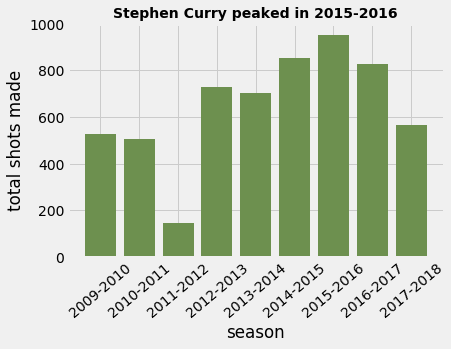

In [0]:
seasons = []
seasons_shots = []
for year in range(2010,2019):
  season = f'{year-1}-{year}'
  seasons.append(season)
  season_begin = f'{year-1}-10-01'
  season_end = f'{year}-06-30'
  df_year = df[(df.game_date >= season_begin) & (df.game_date <= season_end)]
  shots = df_year.shot_made_flag.sum()
  seasons_shots.append(shots)
  
plt.style.use('fivethirtyeight')  
plt.bar(seasons,seasons_shots,color='C3')
plt.title('Stephen Curry peaked in 2015-2016',fontweight='bold',size=14)
plt.xticks(rotation=40)
plt.xlabel('season')
plt.ylabel('total shots made');

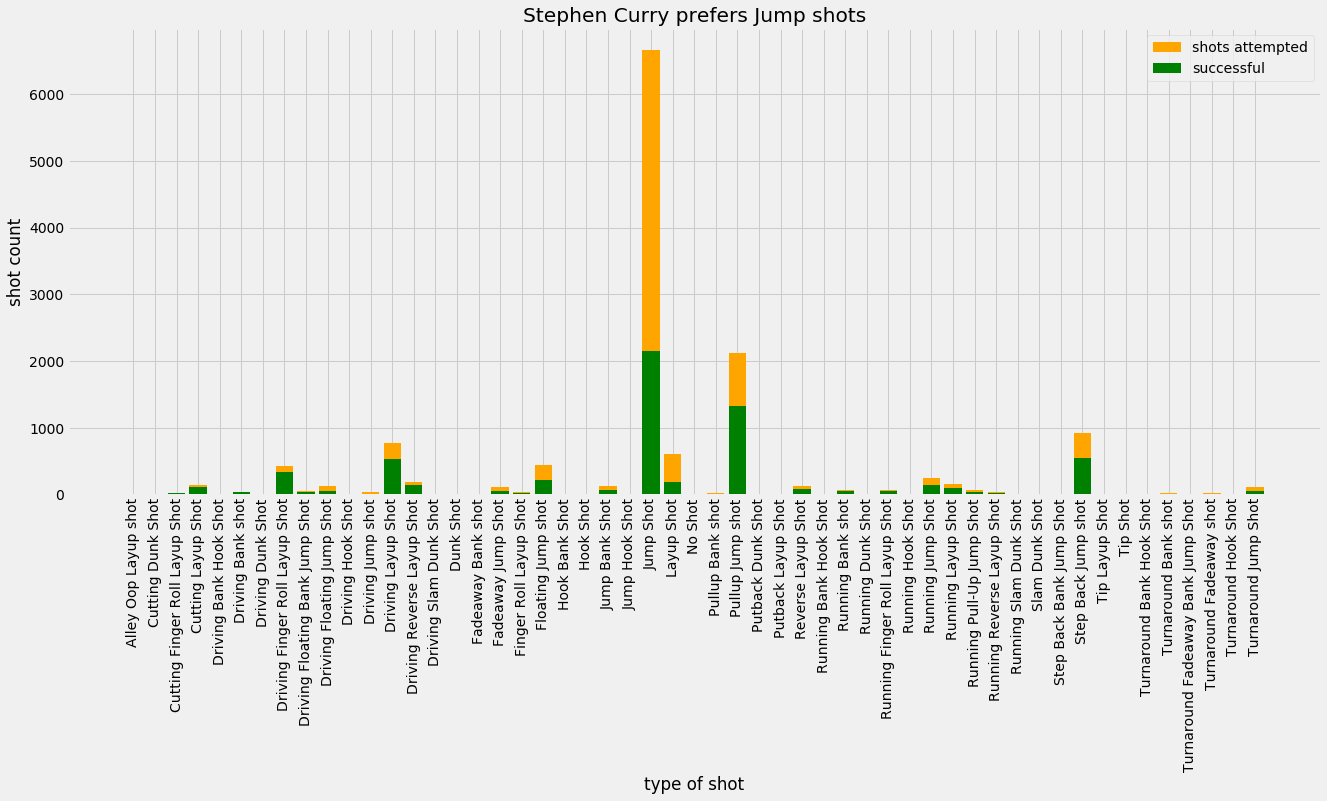

In [0]:
# labels of types of shots made
action_labels = sorted(list(df.action_type.unique()))

# sum of shots made by action
shots_made_by_action = df.groupby('action_type').shot_made_flag.sum().sort_index().values
# sum of attempts of shots
total_attempts_by_action = df.action_type.value_counts().sort_index().values

plt.figure(figsize=(20,8))
plt.bar(action_labels,total_attempts_by_action,color='orange')
plt.bar(action_labels,shots_made_by_action,color='green')
plt.xticks(rotation=90)
plt.title('Stephen Curry prefers Jump shots')
plt.legend(['shots attempted','successful'])
plt.xlabel('type of shot')
plt.ylabel('shot count');

### split training and holdout sets

In [0]:
holdout_set = wrangle(holdout_set)
training_set = wrangle(training_set)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#index

In [0]:
training_set.head()

,period,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,season_type,scoremargin_before_shot,opponent,homecourt_advantage,seconds_remaining_in_period,seconds_remaining_in_game
0,1,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,26,99,249,0,2009-10-28,Regular Season,2.0,HOU,1,685,1405
1,1,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-122,145,1,2009-10-28,Regular Season,0.0,HOU,1,571,1291
2,1,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,14,-60,129,0,2009-10-28,Regular Season,-4.0,HOU,1,362,1082
3,2,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,19,-172,82,0,2009-10-28,Regular Season,-4.0,HOU,1,589,2029
4,2,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-68,148,0,2009-10-28,Regular Season,0.0,HOU,1,139,1579


## **4. Decide how to validate** your model. 

>Choose one of the following options. Any of these options are good. You are not graded on which you choose.
>
>- **Train/validate/test split: train on the 2009-10 season through 2016-17 season, validate with the 2017-18 season.** You'll know you've split the data correctly when your train set has 11,081 observations, and your validation set has 1,168 observations.
>- **Train/validate/test split: random 80/20%** train/validate split.
>- **Cross-validation** with independent test set. You may use any scikit-learn cross-validation method.

In [0]:
y_train = training_set.shot_made_flag
y_test = holdout_set.shot_made_flag


X_train = training_set.drop(columns = ['game_date','shot_made_flag'])
X_test = holdout_set.drop(columns = ['game_date','shot_made_flag'])

## 5. Use a scikit-learn pipeline to encode categoricals and fit a Decision Tree or Random Forest model.

### stretch: optimize hyperparameters

In [0]:
import category_encoders as ce
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

In [0]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         RandomForestClassifier(random_state = 88))

param_distributions = {'randomforestclassifier__n_estimators' : [200],
                       'randomforestclassifier__max_depth' : [10,20,30,None],
                       'randomforestclassifier__min_weight_fraction_leaf' : uniform(.001,.1)}

search = RandomizedSearchCV(pipeline,
                            param_distributions = param_distributions,
                            n_iter = 20,
                            cv = 3,
                            n_jobs = -1,
                            scoring = 'accuracy',
                           verbose=10)

In [0]:
search.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   42.9s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   44.6s finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
                   estimator=Pipeline(memory=None,
                                      steps=[('onehotencoder',
                                              OneHotEncoder(cols=None,
                                                            drop_invariant=False,
                                                            handle_missing='value',
                                                            handle_unknown='value',
                                                            return_df=True,
                                                            use_cat_names=True,
                                                            verbose=0)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(bootstrap=True,
                                                                     class_weight=None,
                                 

#### stretch: 3 optimized hyperparameters:

In [0]:
search.best_params_

{'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__min_weight_fraction_leaf': 0.009905052675931256,
 'randomforestclassifier__n_estimators': 200}

## 6.Get your model's validation accuracy

> (Multiple times if you try multiple iterations.)

In [0]:
print("VALIDATION ACCURACY:\n\nThis model's accuracy:\t",search.best_score_,"\nmean baseline accuracy:\t",mean_baseline)

VALIDATION ACCURACY:

This model's accuracy:	 0.6519715895175117 
mean baseline accuracy:	 0.4729187562688064


## 7. Get your model's test accuracy

> (One time, at the end.)

In [0]:
model = search.best_estimator_

test_accuracy = model.score(X_test,y_test)
print("TEST ACCURACY:\n\nThis model's accuracy:\t",test_accuracy,"\nmean baseline accuracy:\t",mean_baseline)

TEST ACCURACY:

This model's accuracy:	 0.6237565827969573 
mean baseline accuracy:	 0.4729187562688064


## Stretch: feature importances

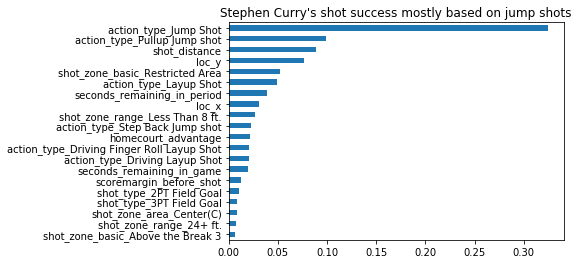

In [0]:
# get feature names and importances saved in variables
feature_importances = model['randomforestclassifier'].feature_importances_
encoder = pipeline.named_steps['onehotencoder']
feature_names = encoder.fit_transform(X_train).columns

# plot top 20 features:
pd.Series(feature_importances,feature_names).sort_values()[-20:].plot.barh()
plt.title("Stephen Curry's shot success mostly based on jump shots") ;

## 8. Given a confusion matrix, calculate accuracy, precision, and recall.

Imagine this is the confusion matrix for a binary classification model. Use the confusion matrix to calculate the model's accuracy, precision, and recall.

<table>
  <tr>
    <td colspan="2" rowspan="2"></td>
    <td colspan="2">Predicted</td>
  </tr>
  <tr>
    <td>Negative</td>
    <td>Positive</td>
  </tr>
  <tr>
    <td rowspan="2">Actual</td>
    <td>Negative</td>
    <td style="border: solid">85</td>
    <td style="border: solid">58</td>
  </tr>
  <tr>
    <td>Positive</td>
    <td style="border: solid">8</td>
    <td style="border: solid"> 36</td>
  </tr>
</table>

### Calculate accuracy 

In [0]:
correct_predictions = 85 + 36
total_predictions = 85 + 58 + 8 + 36
accuracy = correct_predictions/total_predictions
print("accuracy:",accuracy)

accuracy: 0.6470588235294118


### Calculate precision

In [0]:
true_positives = 36
predicted_positives = 36 + 58
precision = true_positives/predicted_positives
print("precision:",precision)

precision: 0.3829787234042553


### Calculate recall

In [0]:
actual_positives = 8 + 36
recall = true_positives / actual_positives
print("recall:",recall)

recall: 0.8181818181818182
